# Systematic uncertainties - background fit example

Author: Aleksander Filip Żarnecki (University of Warsaw)

### (0) Import libraries 

In [1]:
import math
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
# Printout settings
np.set_printoptions(precision=3, linewidth=100, suppress=True)

# More advanced: prevent zeros from being stripped from the end of floats:
np.set_printoptions(formatter={'float_kind': '{: 0.3f}'.format})

### (1) Definition of background model

Consider controlled parameter range is [0,1]

In [3]:
# True background distribution

def mybg(x):
    
    bg = 10.0 - 2* x + x*x
    
    return bg

### (2) Definition of fit model

In [4]:
# Basic functions:  1, x, x^2, x^3 ...

def myfun(x,ifun):

    return np.power(x,ifun)

# Full model

def mymodel(x,par):

    val = np.zeros(x.size)
    
    for ip in range(par.size):
        val+=par[ip]*myfun(x,ip)
        
    return val

### (3) Load pseudo data 

In [5]:
infile = 'http://hep.fuw.edu.pl/u/zarnecki/saed24/10_bg_fit.dat'

indata = np.loadtxt(infile)

ndat = indata.size//3

intab = indata.reshape(ndat,3)

# Considered values of x

xvec = intab[:,0]

# Pseudo-data

yvec = intab[:,1]

# Measurement precision

svec = intab[:,2]
s2vec = svec*svec


In [6]:
# Read background fit output

Nfun = 3

parfile = "http://hep.fuw.edu.pl/u/zarnecki/saed24/10_bg_fit_par_3.dat"
covfile = "http://hep.fuw.edu.pl/u/zarnecki/saed24/10_bg_fit_cov_3.dat"

# Fitted parameters

par = np.loadtxt(parfile)    

# Covariance matrix

cinput = np.loadtxt(covfile)

Cov = cinput.reshape(Nfun,Nfun)

# Inverse of bg covariance matrix

Cinv = np.linalg.inv(Cov)


### (4) Expected background covariance matrix

In [7]:
# Expected bacground values

muvec = mymodel(xvec,par) 

# Matrix of derivatives   $\partial \mu_i / \partial p_j$

Der = np.zeros((xvec.size,Nfun))

for ip in range(Nfun):
    Der[:,ip] = np.power(xvec,ip)

# Error propagation -> expectation covariance matrix

muCov = Der @ Cov @ np.transpose(Der)

# Background erros

muErr = np.sqrt(np.diagonal(muCov))

# Calculate correlation matrix

muCorr = muCov/np.outer(muErr,muErr)



### (5) Eigenvectors

In [8]:
# Calculate eigenvalues and eigenvectors of square matrix

Lam0, muEVec0 = np.linalg.eig(muCorr)

# sort eigenvalues

isL = np.argsort(Lam0)[::-1]

# Take only real part. Imaginary part is due to numerical precision.

Lam=np.real(Lam0[isL])

muEVec = np.real(muEVec0[:,isL])

np.set_printoptions(precision=3)

print("Eigenvalues of the correlation matrix:\n",Lam[:12])

Eigenvalues of the correlation matrix:
 [9.761 6.221 4.019 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]


In [9]:
# Scale relevant eigenvectors to the expected 1 sigma variations
#
# Square roots of eigenvalues give uncertainties along eigenvector directions
# still to be multiplied by uncertainties of individual estimates...

Lmin = 0.0001  # Minimum eigenvalue allowed

EVerr = np.zeros(Lam.size)
nEV = 0

for iv in range(Lam.size):

    if Lam[iv]<=0.01: break
    nEV += 1

    EVerr[iv]=np.sqrt(Lam[iv])
    
    for ix in range(muvec.size):
        muEVec[ix,iv] *= muErr[ix]*EVerr[iv]
       

# Printout
# Square roots of eigenvalues give uncertainties along eigenvector directions
# (still to be multiplied by uncertainties of individual estimates)

print(nEV," eigenvectors found (with significant eigenvalues)")

for iv in range(nEV):
    print("\n Uncertainty (relative %8.5f) along direction %d: " % (EVerr[iv],iv+1))
    print(muEVec[:,iv])

3  eigenvectors found (with significant eigenvalues)

 Uncertainty (relative  3.12418) along direction 1: 
[ 0.016 -0.005 -0.024 -0.041 -0.055 -0.067 -0.077 -0.085 -0.09  -0.094 -0.095 -0.094 -0.09  -0.085
 -0.077 -0.067 -0.055 -0.04  -0.024 -0.005]

 Uncertainty (relative  2.49419) along direction 2: 
[ 0.036  0.041  0.045  0.046  0.046  0.044  0.039  0.033  0.025  0.015  0.003 -0.011 -0.027 -0.045
 -0.064 -0.086 -0.109 -0.135 -0.162 -0.192]

 Uncertainty (relative  2.00463) along direction 3: 
[-0.129 -0.099 -0.072 -0.048 -0.028 -0.011  0.003  0.013  0.02   0.024  0.025  0.022  0.017  0.008
 -0.005 -0.02  -0.039 -0.061 -0.086 -0.115]


### (8) Draw eigenvectors

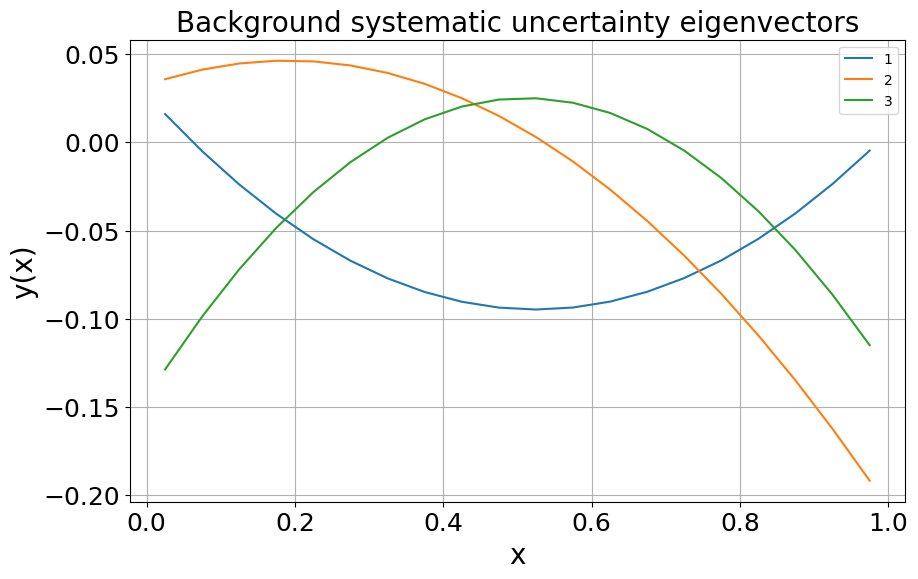

In [10]:
plt.figure(figsize=(10, 6))

for iv in range(nEV):
    plt.plot(xvec,muEVec[:,iv],'-',label=str(iv+1))

plt.title('Background systematic uncertainty eigenvectors',size=20)
plt.xlabel('x',size=20)
plt.ylabel('y(x)',size=20)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(which='major', axis='both')
plt.legend()
fname = '10_bg_fit_ev_'+str(nEV)+'.png'
plt.savefig(fname)

In [11]:
# Check uncertainties resulting from eigenvectors

muErrEV = np.zeros(muvec.size)
muCovEV = np.zeros((muvec.size,muvec.size))

Nuse = 3   # Number of eigenvectors to use

if Nuse > nEV :
    Nuse = nEV

for iv in range(Nuse):
    muErrEV = muErrEV + muEVec[:,iv]*muEVec[:,iv]
    
muErrEV = np.sqrt(muErrEV)

# Covariance matrix

for ix in range(muvec.size):
    for jx in range(muvec.size):
        for iv in range(Nuse):
            muCovEV[ix,jx] = muCovEV[ix,jx] + muEVec[ix,iv]*muEVec[jx,iv]
                
# Printout

print("\n Fitted background:\n\n     x        mu_bg      sigma_bg    sigma_EV\n")

for ix in range(xvec.size):
    print("  %8.3f %8.3f  +/- %6.3f      %6.3f" % (xvec[ix],muvec[ix],muErr[ix],muErrEV[ix]))


muCorrEV = muCovEV/np.outer(muErrEV,muErrEV)



 Fitted background:

     x        mu_bg      sigma_bg    sigma_EV

     0.025    9.843  +/-  0.135       0.135
     0.075    9.772  +/-  0.107       0.107
     0.125    9.701  +/-  0.088       0.088
     0.175    9.633  +/-  0.078       0.078
     0.225    9.565  +/-  0.077       0.077
     0.275    9.500  +/-  0.081       0.081
     0.325    9.435  +/-  0.087       0.087
     0.375    9.372  +/-  0.092       0.092
     0.425    9.311  +/-  0.096       0.096
     0.475    9.250  +/-  0.098       0.098
     0.525    9.192  +/-  0.098       0.098
     0.575    9.134  +/-  0.097       0.097
     0.625    9.078  +/-  0.096       0.096
     0.675    9.024  +/-  0.096       0.096
     0.725    8.970  +/-  0.100       0.100
     0.775    8.919  +/-  0.111       0.111
     0.825    8.868  +/-  0.128       0.128
     0.875    8.820  +/-  0.153       0.153
     0.925    8.772  +/-  0.185       0.185
     0.975    8.726  +/-  0.224       0.224


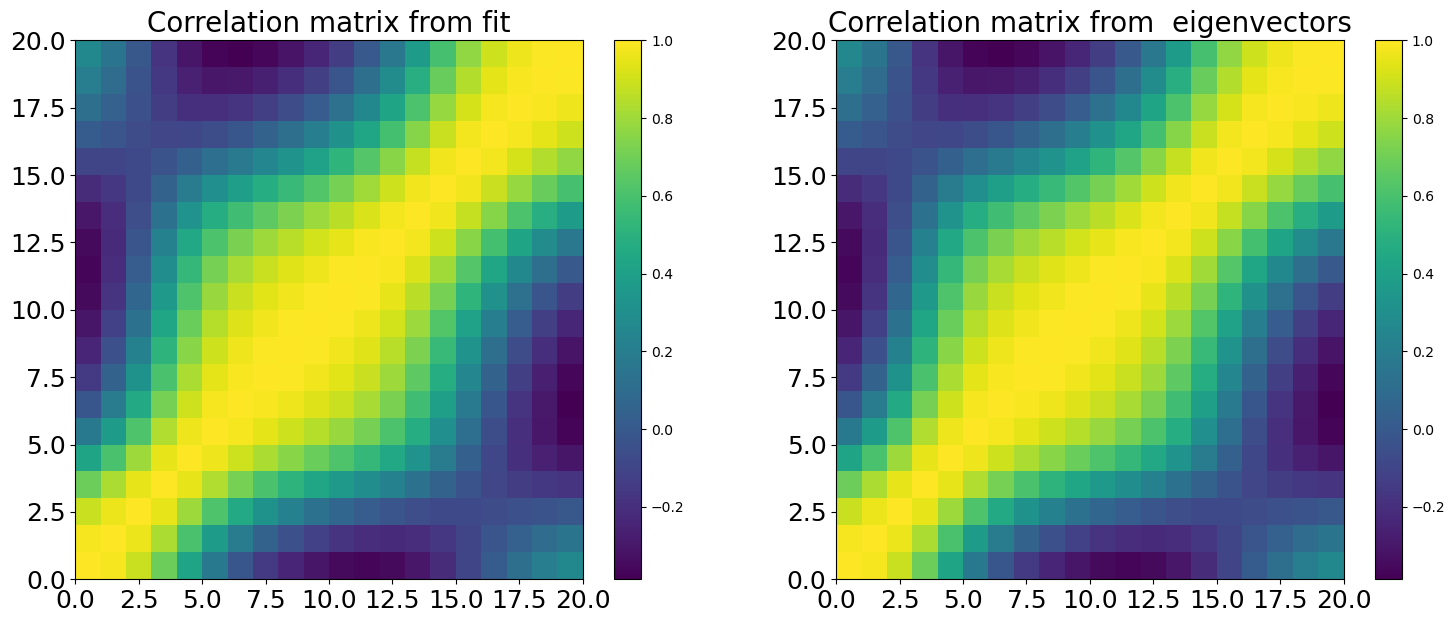

In [12]:
plt.subplots(1,2,figsize=(18, 7))

plt.subplot(121)
plt.pcolormesh(muCorr, cmap='viridis')
plt.colorbar()

plt.title('Correlation matrix from fit',size=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


plt.subplot(122)
plt.pcolormesh(muCorrEV, cmap='viridis')
plt.colorbar()

plt.title('Correlation matrix from  eigenvectors',size=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

fname = '10_bg_fit_ev2_'+str(nEV)+'.png'
plt.savefig(fname)